In [ ]:
import pandas as pd, numpy as np, os, time
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/CS/ML/ML-project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Data functions

In [ ]:
# Global variables
file_train = 'data/train_imputed.csv'
file_test = 'data/validation_imputed.csv'
var_y='no2'
var_time='time'

# Categorize available columns in dataset
cols=['time', 'o3', 'wind', 'temp', 'no2', 'no', 'nox', 'year',
      'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
      'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed',
      'week_1', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_2', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_3', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_4', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_5', 'week_50', 'week_51', 'week_52', 'week_53', 'week_6', 'week_7', 'week_8', 'week_9',
      'day_1', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_2', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_3', 'day_30', 'day_31', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9',
      'hr_0', 'hr_1', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_2', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
      'hday_lundi_de_pâques', 'hday_fête_du_travail', 'hday_fête_de_la_victoire', 'hday_ascension', 'hday_lundi_de_pentecôte', 'hday_fête_nationale', 'hday_assomption', 'hday_toussaint', 'hday_armistice', 'hday_noël', 'hday_jour_de_l_an',
      'hday', 'hday_after1', 'hday_before1']

cols_weather=['wind', 'temp']
cols_hday=['hday', 'hday_after1', 'hday_before1']
cols_specific_hday=[i for i in cols if i.startswith('hday_') and i not in ['hday_after1','hday_before1']]
cols_month=[i for i in cols if i.startswith('month_')]
cols_weekday=['day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed']
cols_day=[i for i in cols if i.startswith('day_') and i not in cols_weekday]
cols_week=[i for i in cols if i.startswith('week_')]
cols_hour=[i for i in cols if i.startswith('hr_')]

def get_lookback(file, lookback_dict):
    data=pd.read_csv(file,parse_dates=[var_time])

    keepcols=[var_time,var_y]
    for key in lookback_dict.keys():
        if lookback_dict[key]>0:
            for i in range(1,lookback_dict[key]+1):
                data[f'{key}_{i}']=data[key].shift(i)
                keepcols.append(f'{key}_{i}')
        else:
            keepcols.append(key)

    # Subset original data
    data=data.loc[max(lookback_dict.values()):,keepcols].set_index(var_time)

    return data

In [ ]:
# df=pd.read_csv('data/train_imputed.csv', parse_dates=['time'], usecols=['time','no2']).rename(columns={"time": "ds", "no2": "y"}, errors="raise")
# val=pd.read_csv('data/validation_imputed.csv', parse_dates=['time'], usecols=['time','no2']).rename(columns={"time": "ds", "no2": "y"}, errors="raise")
# display(df.head(2),df.tail(2), val.head(2), val.tail(2))

# Model functions

In [ ]:
# Train model
def train_prophet(df, val):
  exog=[i for i in df.columns if i not in ['ds','y']]

  m = Prophet(yearly_seasonality=True, daily_seasonality=True)
  for col in exog:
    m.add_regressor(col)
  m.add_country_holidays(country_name='FR')
  print('Holidays in France:',m.train_holiday_names)
  m.fit(df)
  # future = m.make_future_dataframe(periods=24, freq='h')
  future=pd.concat([df.loc[:,['ds']+exog],
                    val.loc[:,['ds']+exog]])
  forecast = m.predict(future)
  return m, forecast

def get_stats(forecast, df, val):
  stats_prophet=pd.merge(forecast[['ds', 'yhat']], pd.concat([df[['ds','y']],val[['ds','y']]]), on='ds').assign(d=lambda x: np.abs(x.y-x.yhat))

  mae_train=stats_prophet[:len(df)].d.mean()
  mae_test=stats_prophet[len(df):].d.mean()
  print(f'train MAE: {mae_train:.4f} \t|| test MAE {mae_test:.4f}')

  rmse_train=np.sqrt((stats_prophet[:len(df)].d**2).mean())
  rmse_test=np.sqrt((stats_prophet[len(df):].d**2).mean())
  print("train RMSE %.4f \t|| test RMSE %.4f" % (rmse_train, rmse_test))
  return stats_prophet.drop(columns=['d']), [mae_train, mae_test, rmse_train, rmse_test]

# UNIVARIATE Models

In [ ]:
np.random.seed(42)
stats={}
for lookback in [1, 12, 24, 72, 168]:
  start_time=time.time()
  print('='*30, lookback, '='*30)
  # DATA
  lookback_dict={**{'no2':lookback}}
  df=get_lookback(file_train, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")
  val=get_lookback(file_test, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")

  # MODEL
  m,forecast=train_prophet(df, val)
  forecast,s=get_stats(forecast, df, val)
  stats[lookback]=s+[time.time()-start_time]

============================== 1 ==============================
Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/86f41bfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/kao8iz_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10231', 'data', 'file=/tmp/tmpq1jux6b9/86f41bfz.json', 'init=/tmp/tmpq1jux6b9/kao8iz_4.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modelnuabev7j/prophet_model-20240123164114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


train MAE: 3.8857 	|| test MAE 3.8723
train RMSE 5.6763 	|| test RMSE 5.9480
============================== 12 ==============================
Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/xvq_wqiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/twuupele.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58815', 'data', 'file=/tmp/tmpq1jux6b9/xvq_wqiq.json', 'init=/tmp/tmpq1jux6b9/twuupele.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modely1s2eai0/prophet_model-20240123164135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:41:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


train MAE: 3.8160 	|| test MAE 3.8328
train RMSE 5.5649 	|| test RMSE 5.8319
============================== 24 ==============================
Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/27pim03_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/cve5d7xt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6004', 'data', 'file=/tmp/tmpq1jux6b9/27pim03_.json', 'init=/tmp/tmpq1jux6b9/cve5d7xt.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modelxnriyifu/prophet_model-20240123164200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


train MAE: 3.7795 	|| test MAE 3.8207
train RMSE 5.5176 	|| test RMSE 5.7788
============================== 72 ==============================
Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/asy51thx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/xgtuig6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85850', 'data', 'file=/tmp/tmpq1jux6b9/asy51thx.json', 'init=/tmp/tmpq1jux6b9/xgtuig6n.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modelo3hq3i1s/prophet_model-20240123164231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:43:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


train MAE: 3.7483 	|| test MAE 3.7818
train RMSE 5.4677 	|| test RMSE 5.7360
============================== 168 ==============================


<ipython-input-3-2afc9cfb5ea0>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-3-2afc9cfb5ea0>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{key}_{i}']=data[key].shift(i)
<ipython-input-3-2afc9cfb5ea0>:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/hus7y4t9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/t30cgxbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78821', 'data', 'file=/tmp/tmpq1jux6b9/hus7y4t9.json', 'init=/tmp/tmpq1jux6b9/t30cgxbh.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modelf2l7zsld/prophet_model-20240123164332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:43:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:44:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1272: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all column

train MAE: 3.7332 	|| test MAE 3.7133
train RMSE 5.4394 	|| test RMSE 5.6410


In [ ]:
check=pd.DataFrame.from_dict(stats).T.reset_index()
check.columns=['lookback','mae_train', 'mae_test', 'rmse_train', 'rmse_test','time']
check

,lookback,mae_train,mae_test,rmse_train,rmse_test,time
0,1,3.885695,3.872336,5.676315,5.947981,20.111978
1,12,3.816023,3.832755,5.564865,5.831949,25.722131
2,24,3.779537,3.820692,5.517596,5.778812,29.067112
3,72,3.748269,3.781819,5.467685,5.735958,52.285239
4,168,3.733188,3.713263,5.439445,5.640976,52.805922


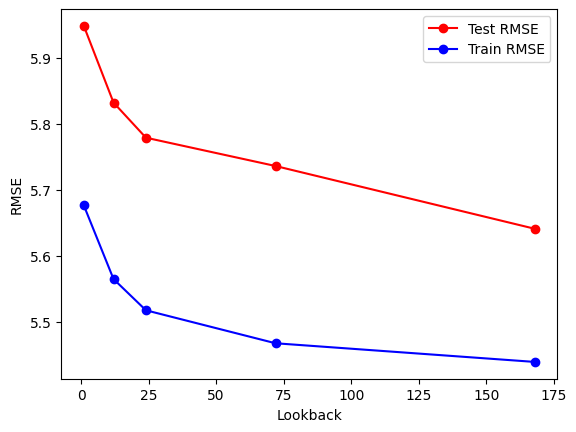

In [ ]:
plt.plot(check['lookback'], check['rmse_test'], "ro-", label='Test RMSE')
plt.plot(check['lookback'], check['rmse_train'], "bo-", label='Train RMSE')

plt.xlabel('Lookback')
plt.ylabel('RMSE')
plt.legend()  # Add a legend to distinguish between test and train RMSE
plt.show()

# Final univar model

In [ ]:
%%time
lookback=24
lookback_dict={**{'no2':lookback}}
df=get_lookback(file_train, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")
val=get_lookback(file_test, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")
m,forecast=train_prophet(df, val)

Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/nqgarirf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/q6160gjr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28849', 'data', 'file=/tmp/tmpq1jux6b9/nqgarirf.json', 'init=/tmp/tmpq1jux6b9/q6160gjr.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modelb56pqh7j/prophet_model-20240123164716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:47:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 9.51 s, sys: 1.8 s, total: 11.3 s
Wall time: 29 s


In [ ]:
plot_plotly(m, forecast)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_components_plotly(m, forecast)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
forecast,s=get_stats(forecast, df, val)

train MAE: 3.7795 	|| test MAE 3.8207
train RMSE 5.5176 	|| test RMSE 5.7788


# MULTIVARIATE models

In [ ]:
np.random.seed(42)
stats={}
lookback=24
for exog_lookback in [1, 12, 24, 72, 168]:
  start_time=time.time()
  print('='*30, exog_lookback, '='*30)
  # DATA
  lookback_dict={**{'no2':lookback, 'wind':exog_lookback, 'temp':exog_lookback}}
  df=get_lookback(file_train, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")
  val=get_lookback(file_test, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")

  # MODEL
  m,forecast=train_prophet(df, val)
  forecast,s=get_stats(forecast, df, val)
  stats[exog_lookback]=s+[time.time()-start_time]

============================== 1 ==============================
Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/xetjo6f6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/uwur09u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49574', 'data', 'file=/tmp/tmpq1jux6b9/xetjo6f6.json', 'init=/tmp/tmpq1jux6b9/uwur09u5.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modelrqipj6h1/prophet_model-20240123184121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


train MAE: 3.7680 	|| test MAE 3.8485
train RMSE 5.4657 	|| test RMSE 5.7359
============================== 12 ==============================
Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/f7qwd6iq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/wepe56an.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11879', 'data', 'file=/tmp/tmpq1jux6b9/f7qwd6iq.json', 'init=/tmp/tmpq1jux6b9/wepe56an.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modeljmlp9asc/prophet_model-20240123184154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


train MAE: 3.7633 	|| test MAE 3.8285
train RMSE 5.4561 	|| test RMSE 5.7173
============================== 24 ==============================
Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/r09ksad8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/3u3ypwhp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36793', 'data', 'file=/tmp/tmpq1jux6b9/r09ksad8.json', 'init=/tmp/tmpq1jux6b9/3u3ypwhp.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_model0kv1q3ir/prophet_model-20240123184250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


train MAE: 3.7530 	|| test MAE 3.8828
train RMSE 5.4344 	|| test RMSE 5.7346
============================== 72 ==============================


<ipython-input-20-2afc9cfb5ea0>:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-20-2afc9cfb5ea0>:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-20-2afc9cfb5ea0>:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-20-2afc9cfb5ea0>:33: PerformanceWarning:

Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/__l29rz8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/0ftenwgo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85844', 'data', 'file=/tmp/tmpq1jux6b9/__l29rz8.json', 'init=/tmp/tmpq1jux6b9/0ftenwgo.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modelllydp4xj/prophet_model-20240123184402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1272: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

train MAE: 3.7458 	|| test MAE 3.8859
train RMSE 5.4121 	|| test RMSE 5.7453
============================== 168 ==============================


<ipython-input-20-2afc9cfb5ea0>:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-20-2afc9cfb5ea0>:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-20-2afc9cfb5ea0>:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-20-2afc9cfb5ea0>:33: PerformanceWarning:

Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/hr3okdvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/86lqj7eu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30492', 'data', 'file=/tmp/tmpq1jux6b9/hr3okdvg.json', 'init=/tmp/tmpq1jux6b9/86lqj7eu.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modeln5kdb8p1/prophet_model-20240123184527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:45:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1272: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

train MAE: 3.7431 	|| test MAE 3.8468
train RMSE 5.3834 	|| test RMSE 5.6699


In [ ]:
check=pd.DataFrame.from_dict(stats).T.reset_index()
check.columns=['lookback','mae_train', 'mae_test', 'rmse_train', 'rmse_test','time']
check

,lookback,mae_train,mae_test,rmse_train,rmse_test,time
0,1,3.767989,3.848499,5.465677,5.735891,37.595150
1,12,3.763333,3.828501,5.456135,5.717297,52.124795
2,24,3.753010,3.882847,5.434420,5.734594,67.635843
3,72,3.745760,3.885850,5.412085,5.745345,69.175860
4,168,3.743143,3.846840,5.383371,5.669858,107.251071


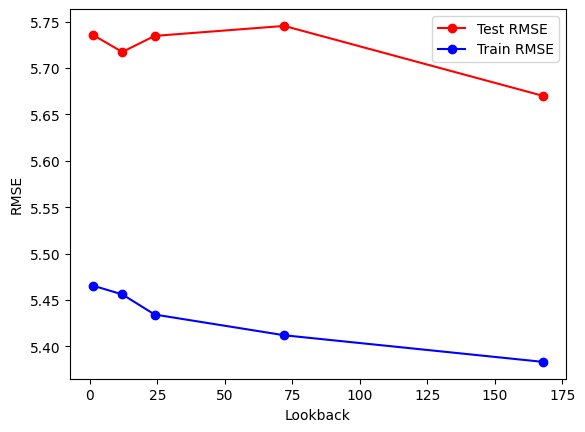

In [ ]:
plt.plot(check['lookback'], check['rmse_test'], "ro-", label='Test RMSE')
plt.plot(check['lookback'], check['rmse_train'], "bo-", label='Train RMSE')

plt.xlabel('Lookback')
plt.ylabel('RMSE')
plt.legend()  # Add a legend to distinguish between test and train RMSE
plt.show()

# Final Multivariate

In [ ]:
%%time
lookback=24
exog_lookback=168
lookback_dict={**{'no2':lookback, 'wind':exog_lookback, 'temp':exog_lookback}}
df=get_lookback(file_train, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")
val=get_lookback(file_test, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")
m,forecast=train_prophet(df, val)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/4yblf5hw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq1jux6b9/bm03pdqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52422', 'data', 'file=/tmp/tmpq1jux6b9/4yblf5hw.json', 'init=/tmp/tmpq1jux6b9/bm03pdqi.json', 'output', 'file=/tmp/tmpq1jux6b9/prophet_modelvp2ui7vl/prophet_model-20240123185117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:51:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1272: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

CPU times: user 45.2 s, sys: 6.86 s, total: 52 s
Wall time: 1min 52s


In [ ]:
plot_plotly(m, forecast)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_components_plotly(m, forecast)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
forecast,s=get_stats(forecast, df, val)

train MAE: 3.7431 	|| test MAE 3.8468
train RMSE 5.3834 	|| test RMSE 5.6699


# Final model

In [ ]:
%%time
file_train = 'data/train_val_imputed.csv'
file_test = 'data/test.csv'

lookback=24
lookback_dict={**{'no2':lookback}}
df=get_lookback(file_train, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")
val=get_lookback(file_test, lookback_dict).reset_index().rename(columns={"time": "ds", "no2": "y"}, errors="raise")
m,forecast=train_prophet(df, val)

Holidays in France: None


DEBUG:cmdstanpy:input tempfile: /tmp/tmph6zh2gya/6sq65zap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph6zh2gya/m3_egz_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2831', 'data', 'file=/tmp/tmph6zh2gya/6sq65zap.json', 'init=/tmp/tmph6zh2gya/m3_egz_y.json', 'output', 'file=/tmp/tmph6zh2gya/prophet_modelg3p1s35p/prophet_model-20240123220428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 10.7 s, sys: 1.89 s, total: 12.6 s
Wall time: 51.3 s


In [ ]:
plot_plotly(m, forecast)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_components_plotly(m, forecast)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
forecast,s=get_stats(forecast, df, val)

train MAE: 3.7628 	|| test MAE 3.2536
train RMSE 5.5604 	|| test RMSE 4.3148


In [ ]:
forecast

,ds,yhat,y
0,2021-07-02 00:00:00,45.017500,53.5
1,2021-07-02 01:00:00,45.895948,59.3
2,2021-07-02 02:00:00,51.544641,52.4
3,2021-07-02 03:00:00,44.129977,34.6
4,2021-07-02 04:00:00,29.112987,27.8
...,...,...,...
22340,2024-01-18 20:00:00,56.459558,63.6
22341,2024-01-18 21:00:00,60.189840,57.0
22342,2024-01-18 22:00:00,50.427874,57.0
22343,2024-01-18 23:00:00,51.249266,57.0


In [ ]:
len(val)

433

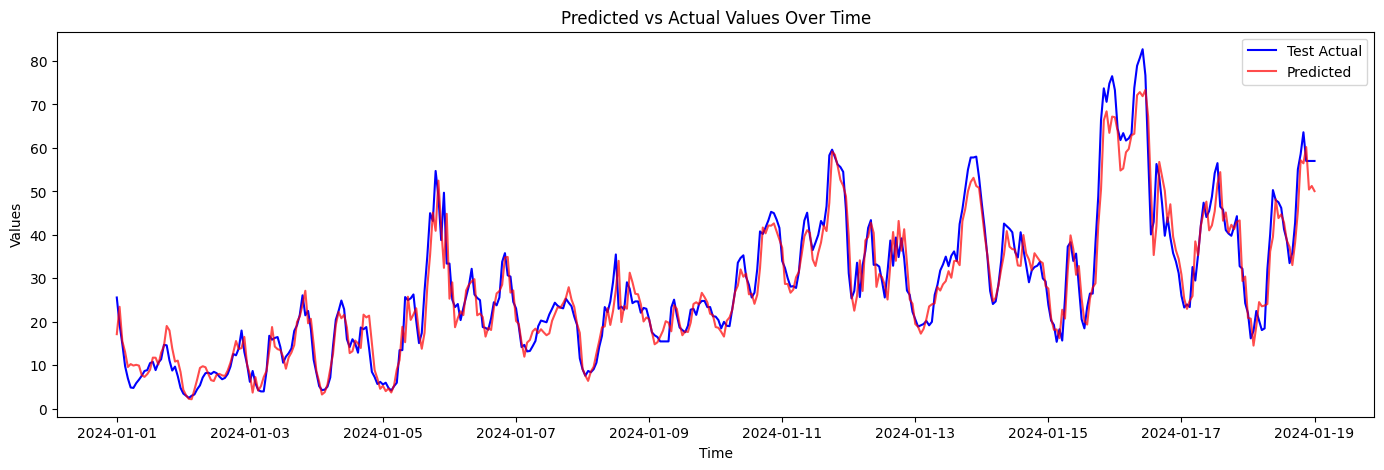

RMSE on Test Set: 4.3148


In [ ]:
check=forecast[-len(val):]

# Calculate RMSE
rmse_test = np.sqrt(((check['y'] - check['yhat']) ** 2).mean())

# Plotting predicted vs actual values in one subplot
fig, axs = plt.subplots(figsize=(17, 5))

# Subplot: Predicted vs Actual Values Over Time
axs.plot(check.ds, check['y'], label='Test Actual', color='b')
axs.plot(check.ds, check['yhat'], label='Predicted', color='r', alpha=0.7)
axs.set_title('Predicted vs Actual Values Over Time')
axs.set_xlabel('Time')
axs.set_ylabel('Values')
axs.legend()

plt.show()
plt.close()

# Display RMSE
print(f'RMSE on Test Set: {rmse_test:.4f}')